## *Análisis del Dataset de insuficiencia cardiaca* heart_failure_clinical_records_dataset.csv de Kaggle

### **Presentado por:**

Angélica Órtiz Álvarez (aortiz016@soyudemedellin.edu.co)

Jhon Jader Diaz Gomez (jdiaz510@soyudemedellin.edu.co)

Cristian Camilo Ospina Metaute (cospina149@soyudemedellin.edu.co)

## Se importan las librerías requeridas para manipulación de datos y manejo de medelos

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from pathlib import Path

## Se carga el dataset heart_failure_clinical_records_dataset.csv de [Kaggle](https://www.ejemplo.com)


In [ ]:
# Se carga de dataset
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()   

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## 🧾 Descripción del Dataset

**Nombre del dataset:** `heart-failure-clinical-data`  
**Fuente:** Kaggle  
**Tipo de problema:** Clasificación binaria  
**Licencia:** Apache 2.0

### 🔍 Variables incluidas:
El dataset contiene variables clínicas relevantes para pacientes con insuficiencia cardíaca. Algunas de las variables clave incluyen:

- `age`: Edad del paciente
- `anaemia`: Presencia de anemia (booleano)
- `creatinine_phosphokinase`: Nivel de la enzima CPK
- `diabetes`: Diagnóstico de diabetes (booleano)
- `ejection_fraction`: Porcentaje de sangre expulsada por el corazón
- `high_blood_pressure`: Presión arterial alta (booleano)
- `platelets`: Recuento de plaquetas
- `serum_creatinine`: Nivel de creatinina en sangre
- `serum_sodium`: Nivel de sodio en sangre
- `sex`: Sexo del paciente
- `smoking`: Fumador (booleano)
- `time`: Tiempo de seguimiento en días
- `DEATH_EVENT`: Variable objetivo (0 = sobrevivió, 1 = falleció)

## 🎯 Objetivo del Estudio

El propósito principal del notebook es comparar el rendimiento de dos modelos de clasificación ampliamente utilizados en la industria:

1. **Regresión Logística**
3. **Bosque Aleatorio (Random Forest)**

### Objetivos específicos:

- Evaluar la capacidad predictiva de cada modelo sobre la variable `DEATH_EVENT`.
- Analizar las ventajas y desventajas de cada enfoque en términos de:
  - Interpretabilidad
  - Precisión
  - Curvas ROC y PR
  - Robustez frente al sobreajuste

## 📈 Aplicaciones del análisis

Este tipo de estudio es útil para:

- Profesionales de la salud que buscan herramientas predictivas para evaluar riesgos clínicos.
- Científicos de datos que desean entender el comportamiento de distintos algoritmos de clasificación en contextos médicos.
- Estudiantes y desarrolladores que exploran técnicas de machine learning aplicadas a datos reales.


## 🧬 Estructura del Dataset `heart-failure-clinical-data`

Este dataset contiene información clínica de pacientes con insuficiencia cardíaca. La tabla siguiente describe cada columna, su tipo de dato y su significado clínico:

| Columna                    | Tipo de dato | Descripción                                                                 |
|----------------------------|--------------|------------------------------------------------------------------------------|
| `age`                      | Numérico     | Edad del paciente en años.                                                  |
| `anaemia`                  | Binario      | Disminución de glóbulos rojos o hemoglobina (1 = sí, 0 = no).               |
| `creatinine_phosphokinase`| Numérico     | Nivel de la enzima CPK en sangre (mcg/L).                                   |
| `diabetes`                 | Binario      | Indica si el paciente tiene diabetes (1 = sí, 0 = no).                      |
| `ejection_fraction`        | Numérico     | Porcentaje de sangre expulsada por el corazón en cada contracción.         |
| `high_blood_pressure`      | Binario      | Indica si el paciente tiene hipertensión (1 = sí, 0 = no).                  |
| `platelets`                | Numérico     | Número de plaquetas en sangre (kiloplaquetas/mL).                           |
| `serum_creatinine`         | Numérico     | Nivel de creatinina en sangre (mg/dL).                                      |
| `serum_sodium`             | Numérico     | Nivel de sodio en sangre (mEq/L).                                           |
| `sex`                      | Binario      | Sexo del paciente (1 = masculino, 0 = femenino).                            |
| `smoking`                  | Binario      | Indica si el paciente fuma (1 = sí, 0 = no).                                |
| `time`                     | Numérico     | Tiempo de seguimiento del paciente (en días).                               |
| `DEATH_EVENT`              | Binario      | Variable objetivo: indica si el paciente falleció durante el seguimiento.  |


## 🔎 Exploración Rápida de Datos (EDA)

Este bloque de código realiza un análisis exploratorio inicial sobre un DataFrame `df`, con el objetivo de comprender su estructura, calidad de datos y detectar la variable objetivo para tareas de clasificación o regresión.

### 🧩 1. Información general del dataset
- **`df.shape`**: Muestra el número de filas y columnas del dataset.
- **`df.columns.tolist()`**: Lista los nombres de las columnas presentes.
- **`df.info()`**: Proporciona información sobre el tipo de datos de cada columna, cantidad de valores no nulos y uso de memoria.

### 📊 2. Estadísticas descriptivas

- Se genera un resumen estadístico de las columnas numéricas: media, desviación estándar, valores mínimos, máximos y percentiles.
- La transposición (`.T`) permite visualizar las estadísticas en formato vertical, facilitando la lectura.

### 🧼 3. Detección de valores nulos

- Se calcula el número de valores nulos por columna para evaluar la calidad del dataset y decidir si es necesario imputar o eliminar datos.

### 🎯 4. Identificación de la variable objetivo

- Se busca automáticamente una columna llamada `target` o `label`, que comúnmente representa la variable objetivo.
- Si no se encuentra, se asume que la última columna podría ser la etiqueta.

### 📈 5. Distribución de la variable objetivo

- Se muestra la distribución de clases en la variable objetivo, útil para detectar desbalance de clases.
- Si no se detecta una columna explícita como `target` o `label`, se analiza la última columna como posible candidata.

In [ ]:
# EDA rápido
print("Shape:", df.shape)
print("\nColumnas:", df.columns.tolist())
print("\nInfo:")
display(df.info())

print("\nDescripción numérica:")
display(df.describe().T)

print("\nValores nulos por columna:")
display(df.isnull().sum())

# Intento identificar la columna target
if 'target' in df.columns:
    print("\nSe detectó columna 'target'.")
elif 'label' in df.columns:
    print("\nSe detectó columna 'label'.")
else:
    print("\nNo se detectó 'target' o 'label' — asumiré que la última columna es la etiqueta si procede.")
    
# Mostrar conteo de la columna que parece target (si existe)
possible_targets = [c for c in ('target','label') if c in df.columns]
if possible_targets:
    tcol = possible_targets[0]
    print(f"\nConteo de valores en '{tcol}':")
    display(df[tcol].value_counts())
else:
    # muestra conteo de la última columna como sugerencia
    last = df.columns[-1]
    print(f"\nMostrando conteo de la última columna ('{last}') por si es la etiqueta:")
    display(df[last].value_counts())

Shape: (299, 13)

Columnas: ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  sm

None


Descripción numérica:


,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0



Valores nulos por columna:


age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


No se detectó 'target' o 'label' — asumiré que la última columna es la etiqueta si procede.

Mostrando conteo de la última columna ('DEATH_EVENT') por si es la etiqueta:


DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

### Después de hacer esta exploración inicial identificamos que hay 13 columnas y 299 registros. Asimismo, se encuentra que no hay nulos y que todos los registros son numéricos

In [118]:
# Tipos, nulos, valores únicos
print("Tipos de datos:")
display(df.dtypes)
print("\nValores nulos por columna:")
display(df.isnull().sum())
print("\nConteos únicos por columna (hasta 10 mostrados):")
display(df.nunique().sort_values(ascending=False).head(20))

# Asegurar que la columna target está presente y es entera
target_col = "DEATH_EVENT"
if target_col not in df.columns:
    raise KeyError(f"No se encontró la columna objetivo '{target_col}' en el dataset.")
df[target_col] = pd.to_numeric(df[target_col], errors="coerce").astype("Int64")
print(f"\nDistribución de {target_col}:")
display(df[target_col].value_counts(dropna=False))

# Corregir posibles columnas numéricas mal tipadas (por ejemplo ages con float)
for c in df.columns:
    if df[c].dtype == "float64" and df[c].dropna().apply(float.is_integer).all():
        # si son floats que representan enteros, convertir a int
        df[c] = df[c].astype("Int64")

Tipos de datos:


age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object


Valores nulos por columna:


age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


Conteos únicos por columna (hasta 10 mostrados):


creatinine_phosphokinase    208
platelets                   176
time                        148
age                          47
serum_creatinine             40
serum_sodium                 27
ejection_fraction            17
diabetes                      2
anaemia                       2
high_blood_pressure           2
sex                           2
smoking                       2
DEATH_EVENT                   2
dtype: int64


Distribución de DEATH_EVENT:


DEATH_EVENT
0    203
1     96
Name: count, dtype: Int64

### Seguidamente, se identifica que de las 13 columnas existentes, existen 6 columnas booleanas que indican si se da o no esa situación. 
"diabetes", "anaemia", "high_blood_pressure", "sex", "smoking", "DEATH_EVENT"

In [119]:
cols_to_bool = [
    "diabetes",
    "anaemia",
    "high_blood_pressure",
    "sex",
    "smoking",
    "DEATH_EVENT"
]

for c in cols_to_bool:
    df[c] = pd.to_numeric(df[c], errors="coerce").map({0: False, 1: True}).astype("boolean")

display(df[cols_to_bool].dtypes)

print("\nConteos por columna (incluye NA si existieran):")
for c in cols_to_bool:
    print(f"\n{c}:")
    display(df[c].value_counts(dropna=False))

diabetes               boolean
anaemia                boolean
high_blood_pressure    boolean
sex                    boolean
smoking                boolean
DEATH_EVENT            boolean
dtype: object


Conteos por columna (incluye NA si existieran):

diabetes:


diabetes
False    174
True     125
Name: count, dtype: Int64


anaemia:


anaemia
False    170
True     129
Name: count, dtype: Int64


high_blood_pressure:


high_blood_pressure
False    194
True     105
Name: count, dtype: Int64


sex:


sex
True     194
False    105
Name: count, dtype: Int64


smoking:


smoking
False    203
True      96
Name: count, dtype: Int64


DEATH_EVENT:


DEATH_EVENT
False    203
True      96
Name: count, dtype: Int64

In [120]:
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    boolean
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    boolean
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    boolean
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    boolean
 10  smoking                   299 non-null    boolean
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    boolean
dtypes: boolean(6), float64(3), int64(4)
memory usage: 20.0 KB


,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
time,299.0,130.260870,77.614208,4.0,73.0,115.0,203.0,285.0


In [121]:
df['age'].unique()

array([75.   , 55.   , 65.   , 50.   , 90.   , 60.   , 80.   , 62.   ,
       45.   , 49.   , 82.   , 87.   , 70.   , 48.   , 68.   , 53.   ,
       95.   , 58.   , 94.   , 85.   , 69.   , 72.   , 51.   , 57.   ,
       42.   , 41.   , 67.   , 79.   , 59.   , 44.   , 63.   , 86.   ,
       66.   , 43.   , 46.   , 61.   , 81.   , 52.   , 64.   , 40.   ,
       60.667, 73.   , 77.   , 78.   , 54.   , 47.   , 56.   ])

In [122]:
bins = [39, 45, 50, 55, 60, 65, 70, 75, 80, 95]
labels = ["40-45", "46-50", "51-55", "56-60", "61-65", "66-70", "71-75", "76-80", "81-95"]

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

df[['age', 'age_group']].head()

,age,age_group
0,75.0,71-75
1,55.0,51-55
2,65.0,61-65
3,50.0,46-50
4,65.0,61-65


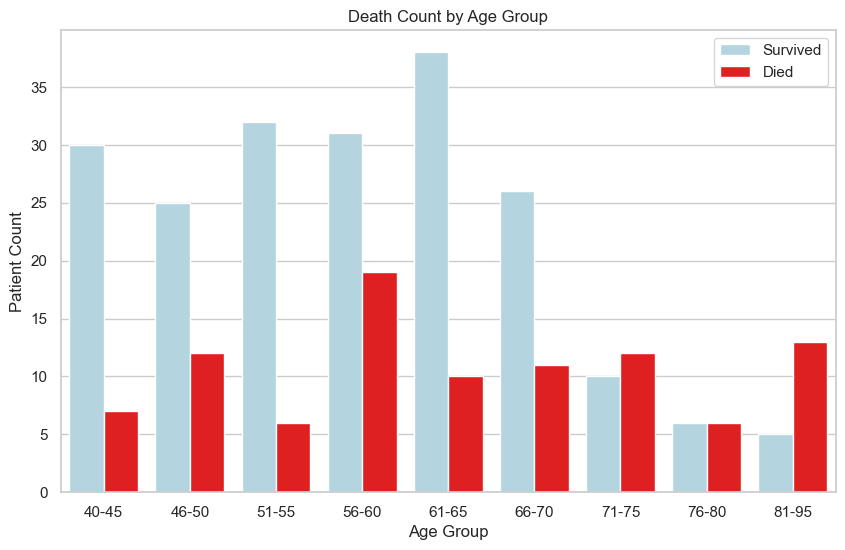

In [123]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='age_group', hue='DEATH_EVENT', palette=["lightblue", "red"])
plt.title("Death Count by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Patient Count")
plt.legend(["Survived", "Died"])
plt.show()

La gráfica muestra que, aunque los grupos de edad intermedios (ej. 51–65) concentran el mayor número absoluto de pacientes sobrevivientes, la proporción de fallecidos aumenta claramente en los grupos de mayor edad; especialmente 71–75 y 81–95 presentan tasas de mortalidad notablemente más altas que los grupos jóvenes; esto sugiere una relación positiva entre edad y riesgo de muerte durante el seguimiento.

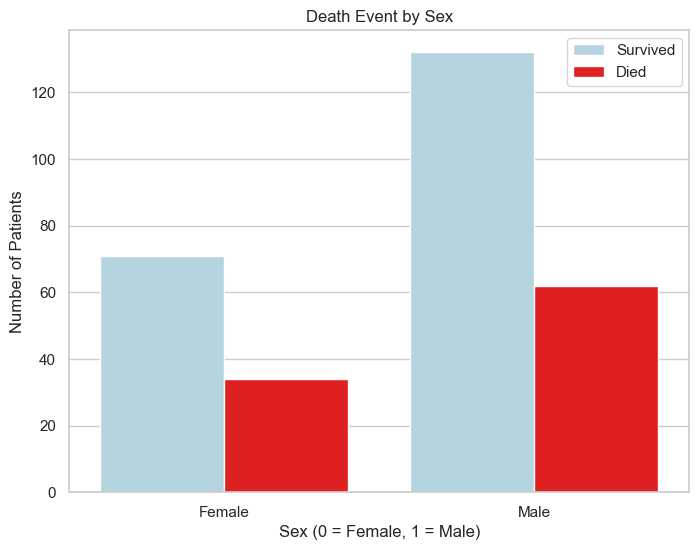

In [124]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='sex', hue='DEATH_EVENT', palette=["lightblue", "red"])

plt.title("Death Event by Sex")
plt.xlabel("Sex (0 = Female, 1 = Male)")
plt.ylabel("Number of Patients")
plt.legend(["Survived", "Died"])
plt.xticks([0, 1], ["Female", "Male"])
plt.show()

En la gráfica por sexo se observa que hay más pacientes hombres que mujeres y, en valores absolutos, también más muertes entre los hombres; no obstante, al mirar la proporción de fallecidos dentro de cada grupo la diferencia parece menos contundente y podría ser pequeña o nula —es decir, el mayor número de muertes en hombres puede deberse en parte al mayor tamaño de esa submuestra. 

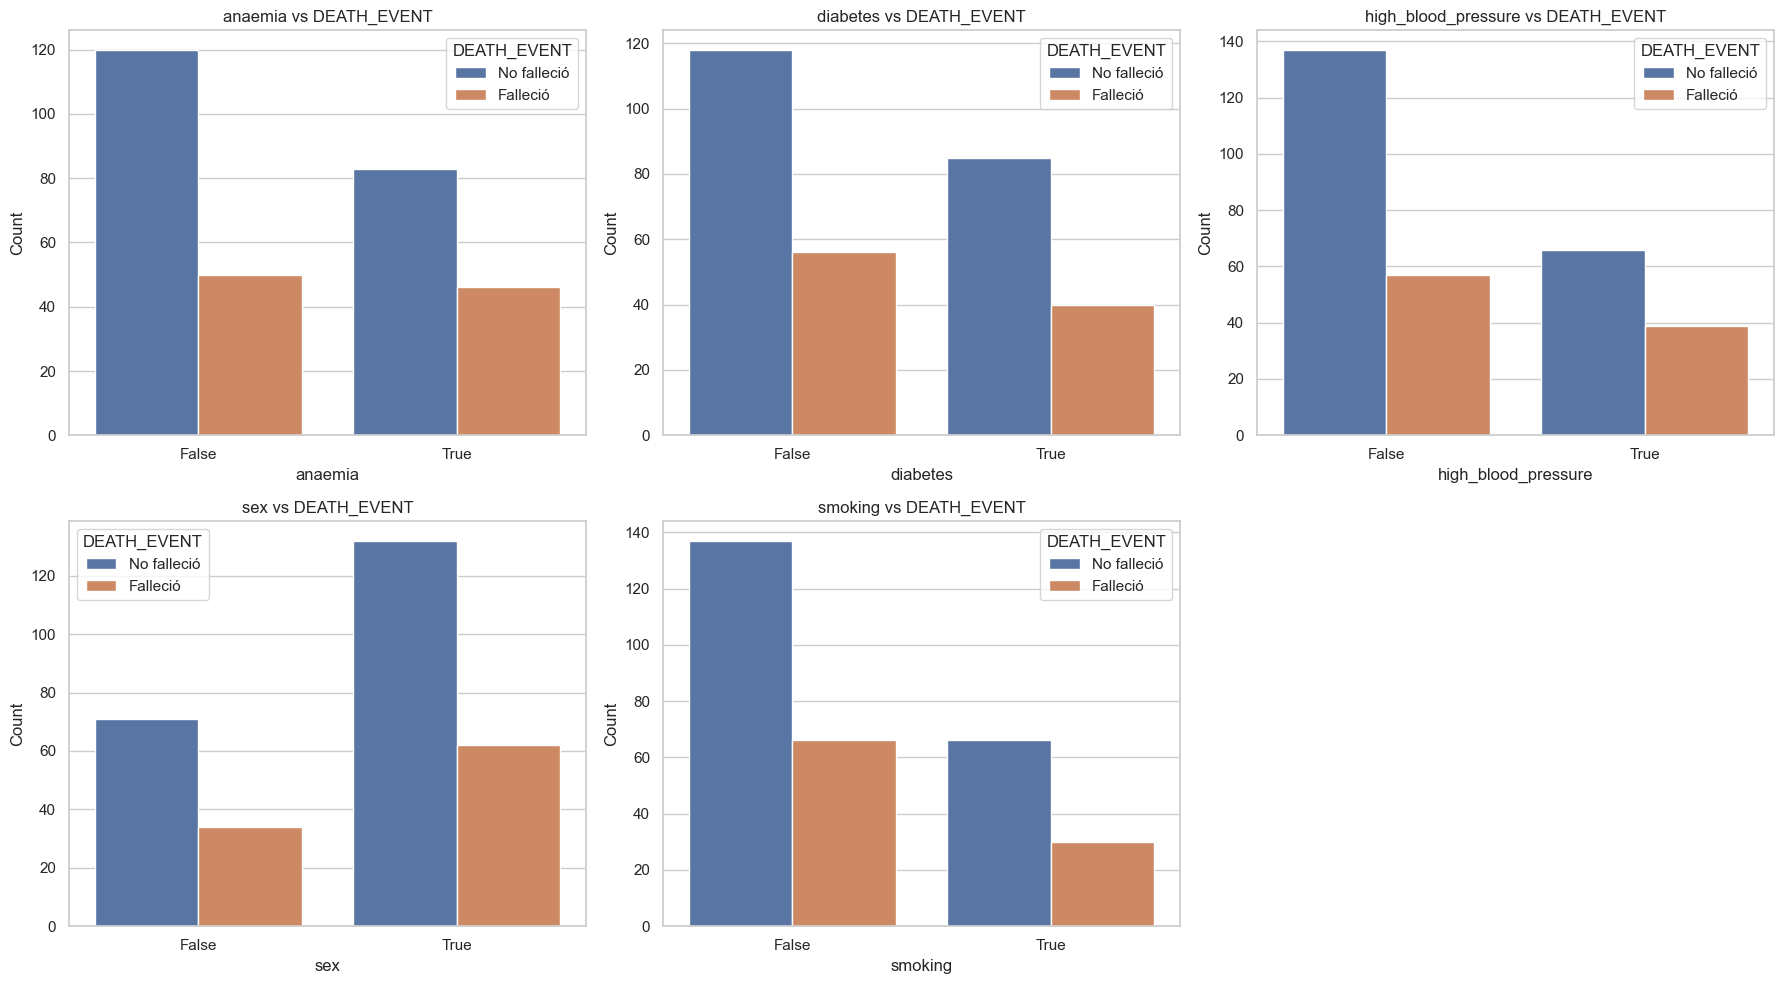

In [125]:
# Variables binarias que quieres comparar
binary_vars = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

# Crear subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

# Graficar cada variable
for i, var in enumerate(binary_vars):
    sns.countplot(data=df, x=var, hue='DEATH_EVENT', ax=axes[i])
    axes[i].set_title(f'{var} vs DEATH_EVENT')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='DEATH_EVENT', labels=['No falleció', 'Falleció'])

# Eliminar subplot vacío si hay uno
if len(binary_vars) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

Anaemia
Observación visual: la barra roja (fallecidos) relativa al total del grupo parece más alta en pacientes con anaemia (True) que en los que no tienen anaemia (False).
Interpretación: sugiere que la presencia de anemia está asociada a una mayor proporción de fallecimientos en el seguimiento. Clínicamente plausible: la anemia puede reflejar peor estado general o comorbilidades.
Señal: moderada-fuerte visualmente (la diferencia de proporción es notable).

Diabetes
Observación visual: también aquí la proporción de muertes parece mayor entre los diabéticos (True) que entre los no diabéticos.
Interpretación: indica una asociación positiva entre diabetes y mortalidad. Podría reflejar mayor carga de comorbilidad o peor pronóstico.
Señal: moderada; la diferencia es apreciable pero no tan grande como en algunos otros factores (según la gráfica).

High_blood_pressure (hipertensión)
Observación visual: se ve un mayor número absoluto de muertes en quienes tienen hipertensión (True) comparado con No, y la proporción de muertes dentro de «True» parece superior.
Interpretación: hipertensión podría asociarse a mayor riesgo, aunque en muchos estudios su efecto depende de control, edad y otros factores cardiovasculares.
Señal: moderada; comparable a diabetes/anaemia.

Sex (sexo)
Observación visual: hay muchos más hombres que mujeres en la muestra; en valores absolutos hay más muertes entre hombres (barra roja masculina mayor).
Interpretación: el mayor número de muertes en hombres podría deberse a (a) mayor tamaño de la submuestra masculina o (b) un riesgo real mayor en hombres. Visualmente, la proporción no parece tan distinta como los conteos absolutos; por tanto la diferencia puede ser en gran parte por el mayor número de hombres.
Señal: débil-moderada; necesita comparar proporciones (tasa de muerte por sexo) antes de concluir un efecto fuerte.

Smoking (tabaquismo)
Observación visual: los fumadores (True) muestran una proporción de fallecidos claramente mayor que los no fumadores.
Interpretación: tabaquismo asociado a mayor mortalidad, coherente con efectos sobre enfermedad cardiovascular y comorbilidades.
Señal: moderada-fuerte.

<Axes: >

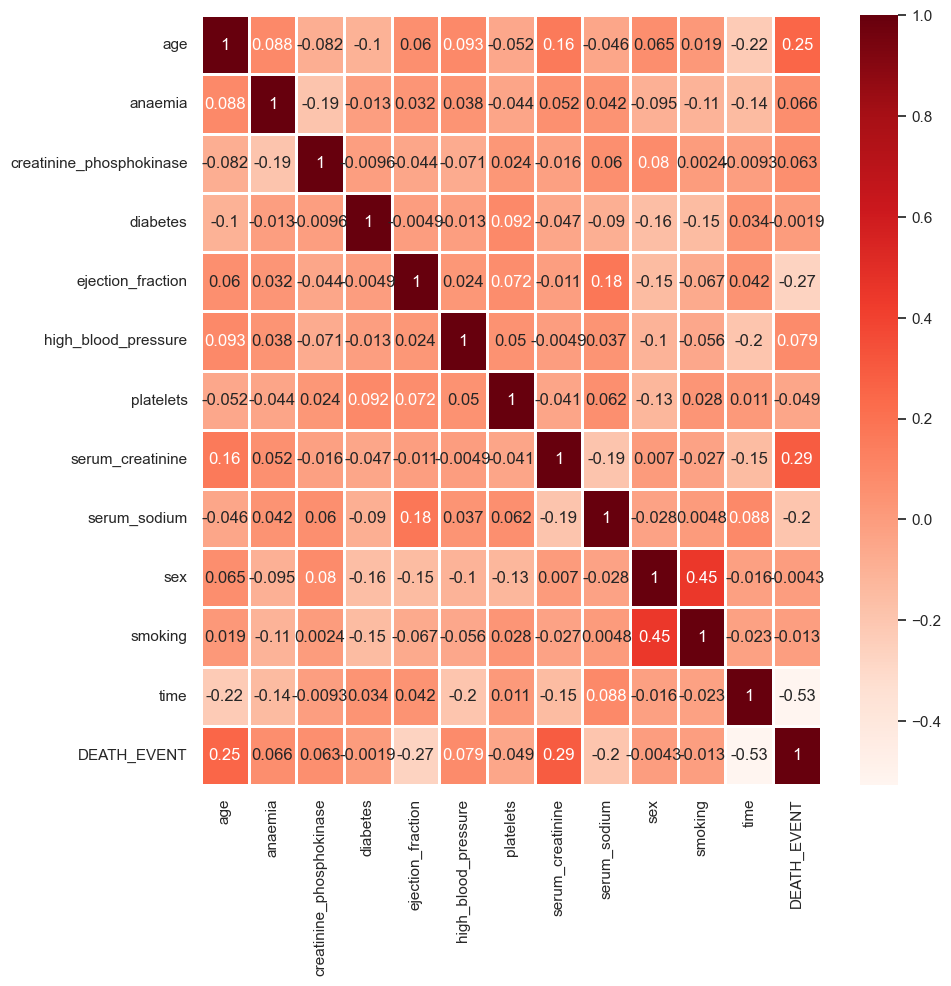

In [126]:
df.drop(columns=['age_group'], inplace=True)
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),cmap="Reds",annot=True,linewidth=1)

La matriz muestra que las variables más asociadas con la muerte son serum_creatinine (r ≈ +0.29) y age (r ≈ +0.25), mientras que ejection_fraction presenta una correlación negativa relevante (r ≈ −0.27): es decir, mayor creatinina y edad y menor fracción de eyección se asocian con mayor probabilidad de DEATH_EVENT. También destaca serum_sodium con correlación negativa moderada (≈ −0.20). Muchas de las variables binarias (anaemia, diabetes, hipertensión, smoking, sex) tienen correlaciones pequeñas con DEATH_EVENT en términos de Pearson, aunque visualmente algunas muestran señales; además sex y smoking están moderadamente correlacionadas entre sí (≈ +0.45).

Prueba commit